# NOAA GEFS Basin Forecasts and Local Historical Data

This notebook extracts forecast data for each basin centroid from the NOAA GEFS 35-day forecast dataset, uses local historical weather data instead of downloading from Open-Meteo, and combines them into a single dataset.

## Overview

The process consists of the following steps:
1. Load basin centroid coordinates from a CSV file with updated basin ID mapping (DE1-DE5)
2. Connect to the NOAA GEFS forecast dataset
3. Extract forecast data for each basin location using all available initialization times
4. Compute quartiles (25th, 50th, 75th percentiles) from ensemble forecasts as separate variables
5. Load historical weather data from local CSV files stored under data/harz/timeseries
6. Interpolate forecast quartiles to hourly resolution
7. Merge the historical and hourly forecast quartile data into a combined dataset
8. Visualize and analyze the combined forecast and historical data
9. Save the combined hourly data to NetCDF files

In [1]:
# Import required libraries
import os
import sys
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings

# Import functions from neuralhydrology datautils module
from neuralhydrology.datautils.fetch_basin_forecasts import (
    load_basin_centroids,
    fetch_forecasts_for_basins,
    interpolate_to_hourly,
)

# Suppress warnings
warnings.filterwarnings('ignore')

## Define Paths for Input and Output Data

In [2]:
# Define paths for input and output data
basin_centroids_file = "../../data/harz/basin_centroids/basin_centroids.csv"  # File containing basin centroid coordinates
timeseries_dir = "../../data/harz/timeseries"  # Directory containing local historical data files
output_dir = "../../data/harz/basin_data"  # Directory for output data (plots and netcdf)

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

print(f"Basin centroids file: {basin_centroids_file}")
print(f"Local timeseries directory: {timeseries_dir}")
print(f"Output directory: {output_dir}")

Basin centroids file: ../../data/harz/basin_centroids/basin_centroids.csv
Local timeseries directory: ../../data/harz/timeseries
Output directory: ../../data/harz/basin_data


## Load Basin Centroids

Load the basin centroid coordinates from the CSV file.

In [3]:
# Load basin centroids and update basin names to use DE1-DE5 mapping
centroids = load_basin_centroids(basin_centroids_file)

# Create basin ID mapping
basin_mapping = {
    'innerste_reservoir_catchment_Basin_0': 'DE1',
    'oker_reservoir_catchment_Basin_0': 'DE2', 
    'ecker_reservoir_catchment_Basin_0': 'DE3',
    'soese_reservoir_catchment_Basin_0': 'DE4',
    'grane_reservoir_catchment_Basin_0': 'DE5'
}

# Update basin names in centroids dataframe
centroids['original_basin_name'] = centroids['basin_name'].copy()
centroids['basin_name'] = centroids['basin_name'].map(basin_mapping)

# Display the updated basin coordinates
print("Updated basin mapping:")
display(centroids[['original_basin_name', 'basin_name', 'latitude', 'longitude']])

Updated basin mapping:


,original_basin_name,basin_name,latitude,longitude
0,innerste_reservoir_catchment_Basin_0,DE1,51.834451,10.307828
1,oker_reservoir_catchment_Basin_0,DE2,51.816468,10.447276
2,ecker_reservoir_catchment_Basin_0,DE3,51.810056,10.584058
3,soese_reservoir_catchment_Basin_0,DE4,51.752310,10.383225
4,grane_reservoir_catchment_Basin_0,DE5,51.884391,10.357203


## Load NOAA GEFS Forecast Dataset

Connect to the online NOAA GEFS forecast dataset hosted by dynamical.org.

In [4]:
# Install dependencies if needed
# %pip install "xarray[complete]>=2025.1.2" "zarr>=3.0.4" requests aiohttp

In [4]:
# Load the NOAA GEFS forecast dataset
print("Loading NOAA GEFS dataset...")
ds = xr.open_zarr(
    "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com", 
    decode_timedelta=True
)

print("\nDataset summary:")
print(f"Time domain: {ds.attrs.get('time_domain', 'N/A')}")
print(f"Forecast domain: {ds.attrs.get('forecast_domain', 'N/A')}")
print(f"Spatial resolution: {ds.attrs.get('spatial_resolution', 'N/A')}")
print(f"\nDataset dimensions:")
for dim, size in ds.dims.items():
    print(f"  {dim}: {size}")

# Show the available initialization times (limited to last 10 for display)
init_times = pd.to_datetime(ds.init_time.values)
print(f"\nTotal number of initialization times: {len(init_times)}")
print(f"First initialization time: {init_times[0].strftime('%Y-%m-%d %H:%M')}")
print(f"Last initialization time: {init_times[-1].strftime('%Y-%m-%d %H:%M')}")

Loading NOAA GEFS dataset...

Dataset summary:
Time domain: Forecasts initialized 2020-10-01 00:00:00 UTC to Present
Forecast domain: Forecast lead time 0-840 hours (0-35 days) ahead
Spatial resolution: 0-240 hours: 0.25 degrees (~20km), 243-840 hours: 0.5 degrees (~40km)

Dataset dimensions:
  init_time: 1730
  ensemble_member: 31
  lead_time: 181
  latitude: 721
  longitude: 1440

Total number of initialization times: 1730
First initialization time: 2020-10-01 00:00
Last initialization time: 2025-06-26 00:00


## Extract Forecasts for Basin Centroids

Extract the forecast data for each basin centroid location using all available initialization times.

In [5]:
# Option to limit the number of initialization times for testing or specific analysis
# Uncomment and modify the code below to use specific initialization times

# Use the most recent 5 initialization times to speed up processing
# recent_times = ds.init_time.values[-5:]
# ds_limited = ds.sel(init_time=recent_times)
# print(f"Limited analysis to the {len(recent_times)} most recent initialization times")

# Use all available initialization times for comprehensive analysis
# Set init_time to None to use all available times
init_time = None

# Extract forecasts for all basin centroids using updated basin names
basin_forecasts = fetch_forecasts_for_basins(ds, centroids, init_time)

# Update basin coordinate to use new DE1-DE5 naming
basin_forecasts = basin_forecasts.assign_coords(basin=centroids['basin_name'].values)

# Check how many basin forecasts we've extracted
print(f"\nExtracted forecasts for {len(basin_forecasts.basin)} basins: {list(basin_forecasts.basin.values)}")


Extracted forecasts for 5 basins: ['DE1', 'DE2', 'DE3', 'DE4', 'DE5']


In [6]:
basin_forecasts

<xarray.Dataset> Size: 4GB
Dimensions:                                     (basin: 5, init_time: 1730,
                                                 ensemble_member: 31,
                                                 lead_time: 181)
Coordinates:
  * ensemble_member                             (ensemble_member) uint16 62B ...
    expected_forecast_length                    (init_time) timedelta64[ns] 14kB dask.array<chunksize=(1730,), meta=np.ndarray>
    ingested_forecast_length                    (init_time, ensemble_member) timedelta64[ns] 429kB dask.array<chunksize=(1730, 31), meta=np.ndarray>
  * init_time                                   (init_time) datetime64[ns] 14kB ...
    latitude                                    (basin) float64 40B 51.75 ......
  * lead_time                                   (lead_time) timedelta64[ns] 1kB ...
    longitude                                   (basin) float64 40B 10.25 ......
    spatial_ref                                 int64 8B ...
    valid_time                                  (init_time, lead_time) datetime64[ns] 3MB dask.array<chunksize=(1730, 181), meta=np.ndarray>
  * basin                                       (basin) object 40B 'DE1' ... ...
Data variables: (12/21)
    categorical_freezing_rain_surface           (basin, init_time, ensemble_member, lead_time) float32 194MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    categorical_ice_pellets_surface             (basin, init_time, ensemble_member, lead_time) float32 194MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    categorical_rain_surface                    (basin, init_time, ensemble_member, lead_time) float32 194MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    categorical_snow_surface                    (basin, init_time, ensemble_member, lead_time) float32 194MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    downward_long_wave_radiation_flux_surface   (basin, init_time, ensemble_member, lead_time) float32 194MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    downward_short_wave_radiation_flux_surface  (basin, init_time, ensemble_member, lead_time) float32 194MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    ...                                          ...
    temperature_2m                              (basin, init_time, ensemble_member, lead_time) float32 194MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    total_cloud_cover_atmosphere                (basin, init_time, ensemble_member, lead_time) float32 194MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    wind_u_100m                                 (basin, init_time, ensemble_member, lead_time) float32 194MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    wind_u_10m                                  (basin, init_time, ensemble_member, lead_time) float32 194MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    wind_v_100m                                 (basin, init_time, ensemble_member, lead_time) float32 194MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    wind_v_10m                                  (basin, init_time, ensemble_member, lead_time) float32 194MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
Attributes:
    dataset_id:           noaa-gefs-forecast-35-day
    dataset_version:      0.2.0
    name:                 NOAA GEFS forecast, 35 day
    description:          Weather forecasts from the Global Ensemble Forecast...
    attribution:          NOAA NWS NCEP GEFS data processed by dynamical.org ...
    spatial_domain:       Global
    spatial_resolution:   0-240 hours: 0.25 degrees (~20km), 243-840 hours: 0...
    time_domain:          Forecasts initialized 2020-10-01 00:00:00 UTC to Pr...
    time_resolution:      Forecasts initialized every 24 hours.
    forecast_domain:      Forecast lead time 0-840 hours (0-35 days) ahead
    forecast_resolution:  Forecast step 0-240 hours: 3 hourly, 243-840 hours:...

## Compute Forecast Quartiles as Separate Variables

Convert ensemble forecasts to quartiles (25th, 50th, 75th percentiles) as separate variables to reduce data size while preserving key statistical information. Each original variable will result in three new variables with suffixes _q25, _q50, and _q75.

In [7]:
def compute_forecast_quartiles_as_variables(forecast_ds, quartiles=[0.25, 0.5, 0.75]):
    """
    Compute quartiles from ensemble forecast data as separate variables.
    
    Parameters:
    -----------
    forecast_ds : xarray.Dataset
        Dataset with ensemble_member dimension
    quartiles : list
        List of quantiles to compute (default: [0.25, 0.5, 0.75])
    
    Returns:
    --------
    xarray.Dataset
        Dataset with separate variables for each quartile, without ensemble_member dimension
    """
    print(f"Computing quartiles {quartiles} from ensemble forecasts as separate variables...")
    
    # Define quartile suffixes
    quartile_suffixes = {
        0.25: '_q25',
        0.5: '_q50', 
        0.75: '_q75'
    }
    
    # Create new dataset with quartile variables
    new_data_vars = {}
    
    # Process each data variable
    for var_name in forecast_ds.data_vars:
        print(f"Processing variable: {var_name}")
        var_data = forecast_ds[var_name]
        
        # Compute quartiles for this variable
        var_quartiles = var_data.quantile(quartiles, dim='ensemble_member')
        
        # Create separate variables for each quartile
        for i, q in enumerate(quartiles):
            suffix = quartile_suffixes.get(q, f'_q{int(q*100)}')
            new_var_name = f"{var_name}{suffix}"
            
            # Extract the quartile data (remove the quantile dimension)
            quartile_data = var_quartiles.isel(quantile=i).drop('quantile')
            
            # Add to new data variables
            new_data_vars[new_var_name] = quartile_data
    
    # Create new dataset with the same coordinates (excluding ensemble_member)
    coords_to_keep = {k: v for k, v in forecast_ds.coords.items() if 'ensemble_member' not in v.dims}
    
    # Create the new dataset
    quartile_ds = xr.Dataset(
        data_vars=new_data_vars,
        coords=coords_to_keep,
        attrs=forecast_ds.attrs.copy()
    )
    
    # Update attributes
    quartile_ds.attrs['quartile_processing'] = f'Computed quartiles {quartiles} as separate variables'
    quartile_ds.attrs['original_ensemble_members'] = len(forecast_ds.ensemble_member)
    
    print(f"Original dataset dimensions: {dict(forecast_ds.dims)}")
    print(f"Quartile dataset dimensions: {dict(quartile_ds.dims)}")
    print(f"Original variables: {len(forecast_ds.data_vars)}")
    print(f"New quartile variables: {len(quartile_ds.data_vars)}")
    
    return quartile_ds

# Apply quartile computation to basin forecasts
basin_forecasts_quartiles = compute_forecast_quartiles_as_variables(basin_forecasts)

# Display the quartile dataset
basin_forecasts_quartiles

Computing quartiles [0.25, 0.5, 0.75] from ensemble forecasts as separate variables...
Processing variable: categorical_freezing_rain_surface
Processing variable: categorical_ice_pellets_surface
Processing variable: categorical_rain_surface
Processing variable: categorical_snow_surface
Processing variable: downward_long_wave_radiation_flux_surface
Processing variable: downward_short_wave_radiation_flux_surface
Processing variable: geopotential_height_cloud_ceiling
Processing variable: maximum_temperature_2m
Processing variable: minimum_temperature_2m
Processing variable: percent_frozen_precipitation_surface
Processing variable: precipitable_water_atmosphere
Processing variable: precipitation_surface
Processing variable: pressure_reduced_to_mean_sea_level
Processing variable: pressure_surface
Processing variable: relative_humidity_2m
Processing variable: temperature_2m
Processing variable: total_cloud_cover_atmosphere
Processing variable: wind_u_100m
Processing variable: wind_u_10m
Proc

<xarray.Dataset> Size: 792MB
Dimensions:                                         (init_time: 1730, basin: 5,
                                                     lead_time: 181)
Coordinates:
    expected_forecast_length                        (init_time) timedelta64[ns] 14kB dask.array<chunksize=(1730,), meta=np.ndarray>
  * init_time                                       (init_time) datetime64[ns] 14kB ...
    latitude                                        (basin) float64 40B 51.75...
  * lead_time                                       (lead_time) timedelta64[ns] 1kB ...
    longitude                                       (basin) float64 40B 10.25...
    valid_time                                      (init_time, lead_time) datetime64[ns] 3MB dask.array<chunksize=(1730, 181), meta=np.ndarray>
  * basin                                           (basin) object 40B 'DE1' ...
    spatial_ref                                     int64 8B ...
Data variables: (12/63)
    categorical_freezing_rain_surface_q25           (basin, init_time, lead_time) float64 13MB dask.array<chunksize=(1, 1, 64), meta=np.ndarray>
    categorical_freezing_rain_surface_q50           (basin, init_time, lead_time) float64 13MB dask.array<chunksize=(1, 1, 64), meta=np.ndarray>
    categorical_freezing_rain_surface_q75           (basin, init_time, lead_time) float64 13MB dask.array<chunksize=(1, 1, 64), meta=np.ndarray>
    categorical_ice_pellets_surface_q25             (basin, init_time, lead_time) float64 13MB dask.array<chunksize=(1, 1, 64), meta=np.ndarray>
    categorical_ice_pellets_surface_q50             (basin, init_time, lead_time) float64 13MB dask.array<chunksize=(1, 1, 64), meta=np.ndarray>
    categorical_ice_pellets_surface_q75             (basin, init_time, lead_time) float64 13MB dask.array<chunksize=(1, 1, 64), meta=np.ndarray>
    ...                                              ...
    wind_v_100m_q25                                 (basin, init_time, lead_time) float64 13MB dask.array<chunksize=(1, 1, 64), meta=np.ndarray>
    wind_v_100m_q50                                 (basin, init_time, lead_time) float64 13MB dask.array<chunksize=(1, 1, 64), meta=np.ndarray>
    wind_v_100m_q75                                 (basin, init_time, lead_time) float64 13MB dask.array<chunksize=(1, 1, 64), meta=np.ndarray>
    wind_v_10m_q25                                  (basin, init_time, lead_time) float64 13MB dask.array<chunksize=(1, 1, 64), meta=np.ndarray>
    wind_v_10m_q50                                  (basin, init_time, lead_time) float64 13MB dask.array<chunksize=(1, 1, 64), meta=np.ndarray>
    wind_v_10m_q75                                  (basin, init_time, lead_time) float64 13MB dask.array<chunksize=(1, 1, 64), meta=np.ndarray>
Attributes: (12/13)
    dataset_id:                 noaa-gefs-forecast-35-day
    dataset_version:            0.2.0
    name:                       NOAA GEFS forecast, 35 day
    description:                Weather forecasts from the Global Ensemble Fo...
    attribution:                NOAA NWS NCEP GEFS data processed by dynamica...
    spatial_domain:             Global
    ...                         ...
    time_domain:                Forecasts initialized 2020-10-01 00:00:00 UTC...
    time_resolution:            Forecasts initialized every 24 hours.
    forecast_domain:            Forecast lead time 0-840 hours (0-35 days) ahead
    forecast_resolution:        Forecast step 0-240 hours: 3 hourly, 243-840 ...
    quartile_processing:        Computed quartiles [0.25, 0.5, 0.75] as separ...
    original_ensemble_members:  31

## Plot Forecast Quartiles Before Interpolation

Visualize the quartiles of the forecast for a specific basin before interpolation.

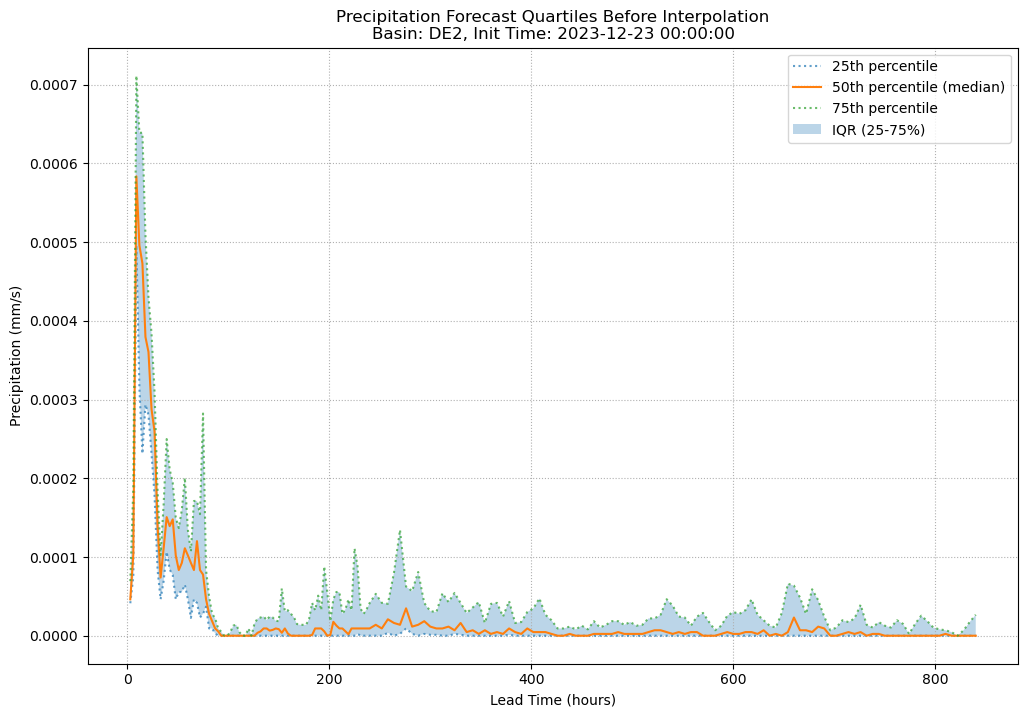

In [10]:
# Select a specific forecast initialization time and basin
forecast_init_time = '2023-12-23 00:00:00'
selected_basin = 'DE2'  # Updated to use new basin ID format

# Extract the forecast dataset for the selected basin and initialization time
plot_ds = basin_forecasts_quartiles.sel(init_time=forecast_init_time, basin=selected_basin)

# Convert lead_time from timedelta to hours for plotting
lead_time_hours = plot_ds['lead_time'].values / np.timedelta64(1, 'h')

# Plot the quartiles for precipitation before interpolation
plt.figure(figsize=(12, 8))

# Plot the three quartiles
plt.plot(lead_time_hours, plot_ds['precipitation_surface_q25'], label='25th percentile', linestyle=':', alpha=0.7)
plt.plot(lead_time_hours, plot_ds['precipitation_surface_q50'], label='50th percentile (median)', linestyle='-')
plt.plot(lead_time_hours, plot_ds['precipitation_surface_q75'], label='75th percentile', linestyle=':', alpha=0.7)

# Fill between 25th and 75th percentiles
plt.fill_between(lead_time_hours, plot_ds['precipitation_surface_q25'], plot_ds['precipitation_surface_q75'], alpha=0.3, label='IQR (25-75%)')

plt.title(f'Precipitation Forecast Quartiles Before Interpolation\nBasin: {selected_basin}, Init Time: {forecast_init_time}')
plt.xlabel('Lead Time (hours)')
plt.ylabel('Precipitation (mm/s)')
plt.legend()
plt.grid(True, linestyle=':')
plt.show()

## Interpolate Forecast Quartiles to Hourly Resolution

The NOAA GEFS forecast dataset provides data at varying temporal resolutions:
- For the first 240 hours (10 days): Data is available at 3-hour intervals
- For hours 243-840 (days 11-35): Data is available at 6-hour intervals

This results in 181 lead time steps over the 35-day forecast period.

We interpolate the forecast quartile values to hourly resolution for the first 10 days (240 hours) using linear interpolation. This provides higher temporal granularity for merging with hourly historical data.

In [8]:
# Apply linear interpolation to convert forecast quartile data to hourly resolution for the first 10 days
print("Interpolating forecast quartile data to hourly resolution for the first 10 days...")

# Process the dataset to get hourly resolution
basin_forecasts_quartiles_hourly = interpolate_to_hourly(basin_forecasts_quartiles, max_hours=240) # 10 days = 240 hours

# Show the new dataset's time dimension
print(f"\nOriginal forecast lead_times: {len(basin_forecasts_quartiles.lead_time)} steps")
print(f"Hourly forecast lead_times: {len(basin_forecasts_quartiles_hourly.lead_time)} steps")

# Compare the resolution before and after
print("\nOriginal forecast lead_time resolution (first 24 hours):")
print(basin_forecasts_quartiles.lead_time[:9].values)

print("\nNew hourly forecast lead_time resolution (first 24 hours):")
print(basin_forecasts_quartiles_hourly.lead_time[:25].values)

# Compare dataset dimensions
print(f"\nOriginal forecast dimensions: {dict(basin_forecasts_quartiles.dims)}")
print(f"Hourly forecast dimensions: {dict(basin_forecasts_quartiles_hourly.dims)}")

# Show sample variable names
sample_vars = list(basin_forecasts_quartiles_hourly.data_vars)[:6]
print(f"\nSample quartile variables: {sample_vars}")

# Preview the hourly forecast dataset
basin_forecasts_quartiles_hourly

Interpolating forecast quartile data to hourly resolution for the first 10 days...

Original forecast lead_times: 181 steps
Hourly forecast lead_times: 240 steps

Original forecast lead_time resolution (first 24 hours):
[             0 10800000000000 21600000000000 32400000000000
 43200000000000 54000000000000 64800000000000 75600000000000
 86400000000000]

New hourly forecast lead_time resolution (first 24 hours):
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]

Original forecast dimensions: {'init_time': 1730, 'basin': 5, 'lead_time': 181}
Hourly forecast dimensions: {'init_time': 1730, 'basin': 5, 'lead_time': 240}

Sample quartile variables: ['categorical_freezing_rain_surface_q25', 'categorical_freezing_rain_surface_q50', 'categorical_freezing_rain_surface_q75', 'categorical_ice_pellets_surface_q25', 'categorical_ice_pellets_surface_q50', 'categorical_ice_pellets_surface_q75']


<xarray.Dataset> Size: 1GB
Dimensions:                                         (init_time: 1730, basin: 5,
                                                     lead_time: 240)
Coordinates:
    expected_forecast_length                        (init_time) timedelta64[ns] 14kB dask.array<chunksize=(1730,), meta=np.ndarray>
  * init_time                                       (init_time) datetime64[ns] 14kB ...
    latitude                                        (basin) float64 40B 51.75...
    longitude                                       (basin) float64 40B 10.25...
  * basin                                           (basin) object 40B 'DE1' ...
    spatial_ref                                     int64 8B ...
  * lead_time                                       (lead_time) int64 2kB 1 ....
Data variables: (12/63)
    categorical_freezing_rain_surface_q25           (basin, init_time, lead_time) float64 17MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    categorical_freezing_rain_surface_q50           (basin, init_time, lead_time) float64 17MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    categorical_freezing_rain_surface_q75           (basin, init_time, lead_time) float64 17MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    categorical_ice_pellets_surface_q25             (basin, init_time, lead_time) float64 17MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    categorical_ice_pellets_surface_q50             (basin, init_time, lead_time) float64 17MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    categorical_ice_pellets_surface_q75             (basin, init_time, lead_time) float64 17MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    ...                                              ...
    wind_v_100m_q25                                 (basin, init_time, lead_time) float64 17MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    wind_v_100m_q50                                 (basin, init_time, lead_time) float64 17MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    wind_v_100m_q75                                 (basin, init_time, lead_time) float64 17MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    wind_v_10m_q25                                  (basin, init_time, lead_time) float64 17MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    wind_v_10m_q50                                  (basin, init_time, lead_time) float64 17MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    wind_v_10m_q75                                  (basin, init_time, lead_time) float64 17MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
Attributes: (12/17)
    dataset_id:                 noaa-gefs-forecast-35-day
    dataset_version:            0.2.0
    name:                       NOAA GEFS forecast, 35 day
    description:                Weather forecasts from the Global Ensemble Fo...
    attribution:                NOAA NWS NCEP GEFS data processed by dynamica...
    spatial_domain:             Global
    ...                         ...
    quartile_processing:        Computed quartiles [0.25, 0.5, 0.75] as separ...
    original_ensemble_members:  31
    interpolation:              Linear interpolation to hourly resolution
    original_resolution:        3-hourly for first 10 days
    max_forecast_hours:         240
    lead_time_format:           Integer hours from 1 to 240

## Plot Forecast Quartiles After Interpolation

Visualize the quartiles of the forecast for a specific basin after interpolation.

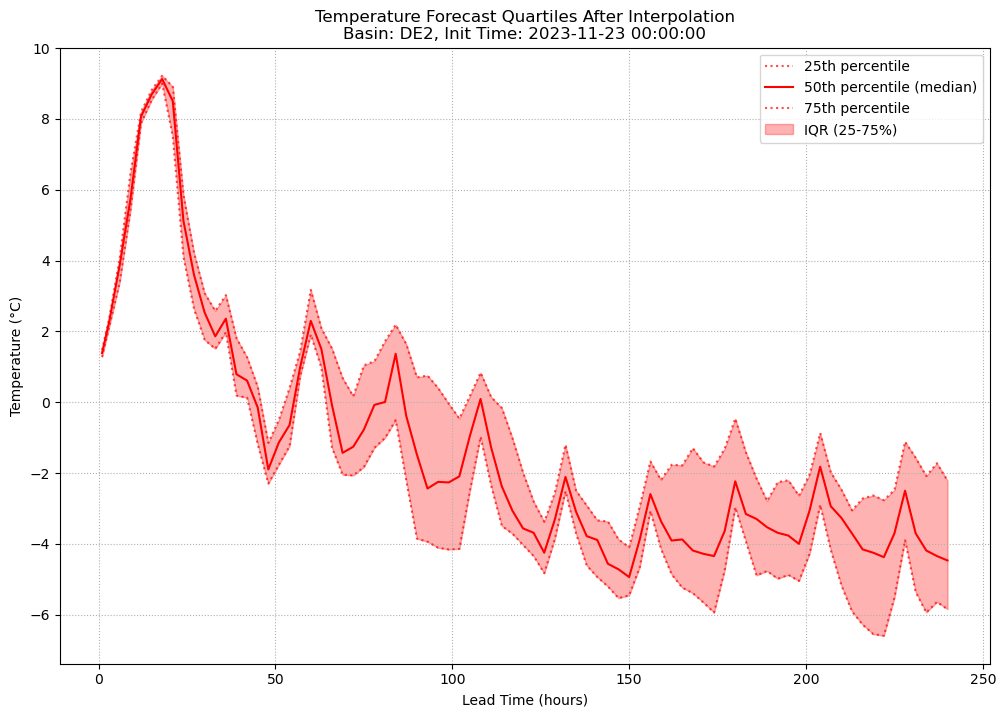

In [12]:
# Select a specific forecast initialization time and basin
forecast_init_time = '2023-11-23 00:00:00'
selected_basin = 'DE2'  # Updated to use new basin ID format

# Extract the forecast dataset for the selected basin and initialization time
plot_ds = basin_forecasts_quartiles_hourly.sel(init_time=forecast_init_time, basin=selected_basin)

# Convert lead_time from integer hours to hours (already in hours for the hourly dataset)
lead_time_hours = plot_ds['lead_time'].values

# Plot the quartiles for temperature after interpolation
plt.figure(figsize=(12, 8))

# Plot the three temperature quartiles
plt.plot(lead_time_hours, plot_ds['temperature_2m_q25'], label='25th percentile', linestyle=':', alpha=0.7, color='red')
plt.plot(lead_time_hours, plot_ds['temperature_2m_q50'], label='50th percentile (median)', linestyle='-', color='red')
plt.plot(lead_time_hours, plot_ds['temperature_2m_q75'], label='75th percentile', linestyle=':', alpha=0.7, color='red')

# Fill between 25th and 75th percentiles
plt.fill_between(lead_time_hours, plot_ds['temperature_2m_q25'], plot_ds['temperature_2m_q75'], alpha=0.3, color='red', label='IQR (25-75%)')

plt.title(f'Temperature Forecast Quartiles After Interpolation\nBasin: {selected_basin}, Init Time: {forecast_init_time}')
plt.xlabel('Lead Time (hours)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True, linestyle=':')
plt.show()

## Load Local Historical Data

Load historical weather data from local CSV files stored under data/harz/timeseries instead of downloading from Open-Meteo.

In [9]:
def load_local_historical_data(timeseries_dir, centroids, start_date, end_date):
    """
    Load historical weather data from local CSV files.
    
    Parameters:
    -----------
    timeseries_dir : str
        Directory containing historical timeseries CSV files
    centroids : pd.DataFrame
        DataFrame with basin information (must have 'basin_name' column with DE1-DE5 format)
    start_date : str
        Start date in YYYY-MM-DD format
    end_date : str
        End date in YYYY-MM-DD format
    
    Returns:
    --------
    xarray.Dataset
        Dataset with historical variables for all basins
    """
    print(f"Loading local historical data for period: {start_date} to {end_date}")
    
    # Convert date strings to datetime
    start_dt = pd.to_datetime(start_date)
    end_dt = pd.to_datetime(end_date)
    
    basin_data = {}
    basin_names = []
    
    # Load data for each basin
    for _, row in centroids.iterrows():
        basin_id = row['basin_name']  # Should be DE1, DE2, etc.
        basin_names.append(basin_id)
        
        # Construct file path
        csv_file = os.path.join(timeseries_dir, f"hydromet_timeseries_{basin_id}.csv")
        
        if not os.path.exists(csv_file):
            print(f"Warning: File not found for basin {basin_id}: {csv_file}")
            continue
            
        print(f"Loading data for basin {basin_id} from {csv_file}")
        
        # Read CSV file
        df = pd.read_csv(csv_file)
        df['date'] = pd.to_datetime(df['date'])
        
        # Filter to requested date range
        mask = (df['date'] >= start_dt) & (df['date'] <= end_dt)
        df_filtered = df[mask].copy()
        
        if df_filtered.empty:
            print(f"Warning: No data in date range for basin {basin_id}")
            continue
            
        # Set date as index and sort
        df_filtered = df_filtered.set_index('date').sort_index()
        
        # Store data for this basin
        basin_data[basin_id] = df_filtered
        
        print(f"Loaded {len(df_filtered)} records for basin {basin_id}")
    
    if not basin_data:
        print("No historical data loaded for any basin")
        return None
    
    # Convert to xarray Dataset
    # First, get all unique timestamps across basins
    all_times = set()
    for df in basin_data.values():
        all_times.update(df.index)
    all_times = sorted(list(all_times))
    
    # Get all variable names (excluding date which is now index)
    sample_df = next(iter(basin_data.values()))
    variable_names = [col for col in sample_df.columns if col != 'date']
    
    # Create data arrays for each variable
    data_vars = {}
    for var_name in variable_names:
        # Create 2D array: (basin, time)
        data_array = np.full((len(basin_names), len(all_times)), np.nan)
        
        for i, basin_name in enumerate(basin_names):
            if basin_name in basin_data:
                df = basin_data[basin_name]
                if var_name in df.columns:
                    # Reindex to match all_times, filling missing with NaN
                    var_series = df[var_name].reindex(all_times)
                    data_array[i, :] = var_series.values
        
        data_vars[var_name] = (['basin', 'time'], data_array)
    
    # Create coordinates
    coords = {
        'basin': basin_names,
        'time': all_times
    }
    
    # Create Dataset
    historical_ds = xr.Dataset(data_vars, coords=coords)
    
    # Add attributes
    historical_ds.attrs['source'] = 'Local CSV files'
    historical_ds.attrs['data_directory'] = timeseries_dir
    historical_ds.attrs['date_range'] = f"{start_date} to {end_date}"
    
    print(f"Created historical dataset with {len(basin_names)} basins and {len(all_times)} time steps")
    print(f"Variables: {list(variable_names)}")
    
    return historical_ds

# Determine the date range from the forecast data
start_date_hist = pd.to_datetime(basin_forecasts_quartiles.init_time.min().values).strftime('%Y-%m-%d')
end_date_hist = pd.to_datetime(basin_forecasts_quartiles.init_time.max().values).strftime('%Y-%m-%d')
print(f"Historical data range determined by forecast init_times: {start_date_hist} to {end_date_hist}")

# Load historical data from local CSV files
basin_historical_data = load_local_historical_data(timeseries_dir, centroids, start_date_hist, end_date_hist)

# Display historical data summary
if basin_historical_data:
    display(basin_historical_data)
else:
    print("Failed to load historical data.")

Historical data range determined by forecast init_times: 2020-10-01 to 2025-06-26
Loading local historical data for period: 2020-10-01 to 2025-06-26
Loading data for basin DE1 from ../../data/harz/timeseries/hydromet_timeseries_DE1.csv
Loaded 31392 records for basin DE1
Loading data for basin DE2 from ../../data/harz/timeseries/hydromet_timeseries_DE2.csv
Loaded 31392 records for basin DE2
Loading data for basin DE3 from ../../data/harz/timeseries/hydromet_timeseries_DE3.csv
Loaded 31392 records for basin DE3
Loading data for basin DE4 from ../../data/harz/timeseries/hydromet_timeseries_DE4.csv
Loaded 31392 records for basin DE4
Loading data for basin DE5 from ../../data/harz/timeseries/hydromet_timeseries_DE5.csv
Loaded 31392 records for basin DE5
Created historical dataset with 5 basins and 31392 time steps
Variables: ['discharge_vol', 'water_level', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'precipitation', 'rain', 'snowfall', 'surface_pressure', 'et0_fao_evapotransp

<xarray.Dataset> Size: 19MB
Dimensions:                     (basin: 5, time: 31392)
Coordinates:
  * basin                       (basin) <U3 60B 'DE1' 'DE2' 'DE3' 'DE4' 'DE5'
  * time                        (time) datetime64[ns] 251kB 2020-10-01 ... 20...
Data variables: (12/15)
    discharge_vol               (basin, time) float64 1MB 9.3 9.3 ... 10.62 10.6
    water_level                 (basin, time) float64 1MB 0.54 0.54 ... 0.15
    temperature_2m              (basin, time) float64 1MB 11.73 11.38 ... 14.83
    relative_humidity_2m        (basin, time) float64 1MB 90.52 90.19 ... 73.96
    dew_point_2m                (basin, time) float64 1MB 10.23 9.83 ... 10.23
    precipitation               (basin, time) float64 1MB 0.0 0.0 ... 0.0 0.0
    ...                          ...
    et0_fao_evapotranspiration  (basin, time) float64 1MB 0.0 0.0 ... 0.01009
    wind_direction_10m          (basin, time) float64 1MB 162.9 165.5 ... 126.9
    soil_moisture_0_to_7cm      (basin, time) float64 1MB 0.31 0.31 ... 0.298
    soil_moisture_7_to_28cm     (basin, time) float64 1MB 0.296 0.296 ... 0.323
    soil_moisture_28_to_100cm   (basin, time) float64 1MB 0.229 0.229 ... 0.34
    shortwave_radiation         (basin, time) float64 1MB 0.0 0.0 ... 0.0 0.0
Attributes:
    source:          Local CSV files
    data_directory:  ../../data/harz/timeseries
    date_range:      2020-10-01 to 2025-06-26

## Merge Historical and Forecast Quartile Data

Combine the fetched historical data and the interpolated hourly forecast quartile data into a single xarray Dataset. The forecast `init_time` coordinate is renamed to `time` to align with the historical data.

The final dataset will have:
- Historical variables with dimensions ('basin', 'time')
- Forecast quartile variables with dimensions ('basin', 'time', 'lead_time')

In [10]:
# Rename 'init_time' in forecast data to 'time' for merging
basin_forecasts_quartiles_hourly_renamed = basin_forecasts_quartiles_hourly.rename({'init_time': 'time'})

# --- Add chunking for historical data ---
if basin_historical_data is not None:
    print("Chunking historical data...")
    basin_historical_data = basin_historical_data.chunk({'time': 'auto', 'basin': 'auto'})
    print("Historical data chunked.")
    # Display chunking info for a sample variable
    if 'temperature_2m' in basin_historical_data:
        print(f"Sample historical variable chunks ('temperature_2m'): {basin_historical_data['temperature_2m'].chunksizes}")
    elif basin_historical_data.data_vars:
        first_var = list(basin_historical_data.data_vars)[0]
        print(f"Sample historical variable chunks ('{first_var}'): {basin_historical_data[first_var].chunksizes}")
# --- End of added chunking ---

# Identify conflicting variable names (present in both historical and forecast)
# We need to rename historical variables that conflict with forecast base variables
conflicting_vars = []
if basin_historical_data is not None:
    # Check for conflicts with base variable names (before quartile suffixes)
    forecast_base_vars = set()
    for var in basin_forecasts_quartiles_hourly_renamed.data_vars:
        # Extract base variable name (remove quartile suffix)
        if var.endswith(('_q25', '_q50', '_q75')):
            base_var = var.rsplit('_q', 1)[0]
            forecast_base_vars.add(base_var)
    
    # Check which historical variables conflict with forecast base variables
    conflicting_vars = [var for var in basin_historical_data.data_vars if var in forecast_base_vars]
    print(f"Found conflicting variables: {conflicting_vars}")

# Rename conflicting variables in the historical dataset to avoid conflicts
rename_dict = {var: f"{var}_hist" for var in conflicting_vars}
basin_historical_data_renamed = basin_historical_data.rename(rename_dict) if basin_historical_data is not None else None
if rename_dict:
    print(f"Renamed conflicting historical variables: {list(rename_dict.values())}")

# Merge the full historical and forecast datasets using 'no_conflicts'
print("Merging full historical and forecast quartile datasets...")
if basin_historical_data_renamed is not None:
    try:
        basin_forecast_historical_hourly = xr.merge([basin_historical_data_renamed, basin_forecasts_quartiles_hourly_renamed], compat='no_conflicts')
        print("\nMerge successful.")
        print(f"Combined Dataset dimensions: {dict(basin_forecast_historical_hourly.dims)}")
        
        # Separate variables by their dimensions for display
        historical_vars = []
        forecast_vars = []
        
        for var_name in basin_forecast_historical_hourly.data_vars:
            var_dims = basin_forecast_historical_hourly[var_name].dims
            if 'lead_time' in var_dims:
                forecast_vars.append(f"{var_name}: {var_dims}")
            else:
                historical_vars.append(f"{var_name}: {var_dims}")
        
        print(f"\nHistorical variables (basin, time): {len(historical_vars)}")
        for var in historical_vars[:10]:  # Show first 10
            print(f"  - {var}")
        if len(historical_vars) > 10:
            print(f"  ... and {len(historical_vars) - 10} more")
        
        print(f"\nForecast variables (basin, time, lead_time): {len(forecast_vars)}")
        for var in forecast_vars[:5]:  # Show first 5
            print(f"  - {var}")
        if len(forecast_vars) > 5:
            print(f"  ... and {len(forecast_vars) - 5} more")
        
        display(basin_forecast_historical_hourly)
    except Exception as e:
        print(f"\nMerge failed: {e}")
        import traceback
        traceback.print_exc()
        # Fallback or further error handling
        basin_forecast_historical_hourly = None
else:
    print("Skipping merge as historical data failed to load or was not renamed.")
    basin_forecast_historical_hourly = basin_forecasts_quartiles_hourly_renamed 
    print("Proceeding with only forecast quartile data.")

Chunking historical data...
Historical data chunked.
Sample historical variable chunks ('temperature_2m'): Frozen({'basin': (5,), 'time': (31392,)})
Found conflicting variables: ['temperature_2m', 'relative_humidity_2m']
Renamed conflicting historical variables: ['temperature_2m_hist', 'relative_humidity_2m_hist']
Merging full historical and forecast quartile datasets...

Merge successful.
Combined Dataset dimensions: {'basin': 5, 'time': 31814, 'lead_time': 240}

Historical variables (basin, time): 15
  - discharge_vol: ('basin', 'time')
  - water_level: ('basin', 'time')
  - temperature_2m_hist: ('basin', 'time')
  - relative_humidity_2m_hist: ('basin', 'time')
  - dew_point_2m: ('basin', 'time')
  - precipitation: ('basin', 'time')
  - rain: ('basin', 'time')
  - snowfall: ('basin', 'time')
  - surface_pressure: ('basin', 'time')
  - et0_fao_evapotranspiration: ('basin', 'time')
  ... and 5 more

Forecast variables (basin, time, lead_time): 63
  - categorical_freezing_rain_surface_q

<xarray.Dataset> Size: 19GB
Dimensions:                                         (basin: 5, time: 31814,
                                                     lead_time: 240)
Coordinates:
  * basin                                           (basin) <U3 60B 'DE1' ......
  * time                                            (time) datetime64[ns] 255kB ...
  * lead_time                                       (lead_time) int64 2kB 1 ....
    expected_forecast_length                        (time) timedelta64[ns] 255kB dask.array<chunksize=(1730,), meta=np.ndarray>
    latitude                                        (basin) float64 40B 51.75...
    longitude                                       (basin) float64 40B 10.25...
    spatial_ref                                     int64 8B ...
Data variables: (12/78)
    discharge_vol                                   (basin, time) float64 1MB dask.array<chunksize=(5, 31814), meta=np.ndarray>
    water_level                                     (basin, time) float64 1MB dask.array<chunksize=(5, 31814), meta=np.ndarray>
    temperature_2m_hist                             (basin, time) float64 1MB dask.array<chunksize=(5, 31814), meta=np.ndarray>
    relative_humidity_2m_hist                       (basin, time) float64 1MB dask.array<chunksize=(5, 31814), meta=np.ndarray>
    dew_point_2m                                    (basin, time) float64 1MB dask.array<chunksize=(5, 31814), meta=np.ndarray>
    precipitation                                   (basin, time) float64 1MB dask.array<chunksize=(5, 31814), meta=np.ndarray>
    ...                                              ...
    wind_v_100m_q25                                 (basin, time, lead_time) float64 305MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    wind_v_100m_q50                                 (basin, time, lead_time) float64 305MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    wind_v_100m_q75                                 (basin, time, lead_time) float64 305MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    wind_v_10m_q25                                  (basin, time, lead_time) float64 305MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    wind_v_10m_q50                                  (basin, time, lead_time) float64 305MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    wind_v_10m_q75                                  (basin, time, lead_time) float64 305MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
Attributes:
    source:          Local CSV files
    data_directory:  ../../data/harz/timeseries
    date_range:      2020-10-01 to 2025-06-26

In [11]:
# Let's examine the final dataset structure more clearly
print("=== FINAL DATASET STRUCTURE ANALYSIS ===\n")

if 'basin_forecast_historical_hourly' in locals() and basin_forecast_historical_hourly is not None:
    ds = basin_forecast_historical_hourly
    
    print("📊 Dataset Dimensions:")
    for dim, size in ds.dims.items():
        print(f"  • {dim}: {size}")
    
    print(f"\n🏷️ Coordinates:")
    for coord in ds.coords:
        coord_info = ds.coords[coord]
        print(f"  • {coord}: {coord_info.dims} - shape {coord_info.shape}")
        if coord == 'time':
            print(f"    └─ Time range: {pd.to_datetime(coord_info.values.min())} to {pd.to_datetime(coord_info.values.max())}")
        elif coord == 'lead_time':
            print(f"    └─ Lead time range: {coord_info.values.min()} to {coord_info.values.max()} hours")
        elif coord == 'basin':
            print(f"    └─ Basins: {list(coord_info.values)}")
    
    print(f"\n📋 Variables by indexing pattern:")
    
    # Separate variables by their dimensions
    hindcast_vars = []  # (basin, time) - historical/hindcast features
    forecast_vars = []  # (basin, time, lead_time) - forecast features
    
    for var_name in ds.data_vars:
        var_dims = ds[var_name].dims
        if var_dims == ('basin', 'time'):
            hindcast_vars.append(var_name)
        elif var_dims == ('basin', 'time', 'lead_time'):
            forecast_vars.append(var_name)
        else:
            print(f"  ⚠️  Unexpected dimensions for {var_name}: {var_dims}")
    
    print(f"\n🔵 HINDCAST FEATURES (basin, time): {len(hindcast_vars)} variables")
    print("   These are indexed only by basin and time (historical/observational data)")
    for i, var in enumerate(hindcast_vars):
        if i < 10:  # Show first 10
            print(f"    • {var}")
    if len(hindcast_vars) > 10:
        print(f"    ... and {len(hindcast_vars) - 10} more")
    
    print(f"\n🔴 FORECAST FEATURES (basin, time, lead_time): {len(forecast_vars)} variables")
    print("   These are indexed by basin, time, and lead_time")
    # Group forecast variables by base variable
    forecast_groups = {}
    for var in forecast_vars:
        if var.endswith(('_q25', '_q50', '_q75')):
            base_var = var.rsplit('_q', 1)[0]
            if base_var not in forecast_groups:
                forecast_groups[base_var] = []
            forecast_groups[base_var].append(var)
    
    print(f"   Organized as {len(forecast_groups)} base variables × 3 quartiles each:")
    for i, (base_var, quartile_vars) in enumerate(forecast_groups.items()):
        if i < 5:  # Show first 5 base variables
            print(f"    • {base_var}: {', '.join([v.split('_q')[1] for v in sorted(quartile_vars)])}")
    if len(forecast_groups) > 5:
        print(f"    ... and {len(forecast_groups) - 5} more base variables")
    
    print(f"\n📈 Example data access patterns:")
    print(f"  • Historical temperature for basin DE2: ds['temperature_2m_hist'].sel(basin='DE2')")
    print(f"  • Forecast temp quartiles for basin DE2 at init time 2023-12-23:")
    print(f"    ds['temperature_2m_q50'].sel(basin='DE2', time='2023-12-23')")
    print(f"  • All forecast quartiles for precipitation at specific time/basin:")
    print(f"    {{q: ds[f'precipitation_surface_q{{q}}'].sel(basin='DE2', time='2023-12-23') for q in ['25', '50', '75']}}")
    
    # Show sample data shape
    sample_hindcast = ds[hindcast_vars[0]] if hindcast_vars else None
    sample_forecast = ds[forecast_vars[0]] if forecast_vars else None
    
    if sample_hindcast is not None:
        print(f"\n📊 Sample hindcast variable '{hindcast_vars[0]}' shape: {sample_hindcast.shape}")
    if sample_forecast is not None:
        print(f"📊 Sample forecast variable '{forecast_vars[0]}' shape: {sample_forecast.shape}")
        
else:
    print("❌ Final dataset not available for analysis")

=== FINAL DATASET STRUCTURE ANALYSIS ===

📊 Dataset Dimensions:
  • basin: 5
  • time: 31814
  • lead_time: 240

🏷️ Coordinates:
  • basin: ('basin',) - shape (5,)
    └─ Basins: [np.str_('DE1'), np.str_('DE2'), np.str_('DE3'), np.str_('DE4'), np.str_('DE5')]
  • time: ('time',) - shape (31814,)
    └─ Time range: 2020-10-01 00:00:00 to 2025-06-26 00:00:00
  • lead_time: ('lead_time',) - shape (240,)
    └─ Lead time range: 1 to 240 hours
  • expected_forecast_length: ('time',) - shape (31814,)
  • latitude: ('basin',) - shape (5,)
  • longitude: ('basin',) - shape (5,)
  • spatial_ref: () - shape ()

📋 Variables by indexing pattern:

🔵 HINDCAST FEATURES (basin, time): 15 variables
   These are indexed only by basin and time (historical/observational data)
    • discharge_vol
    • water_level
    • temperature_2m_hist
    • relative_humidity_2m_hist
    • dew_point_2m
    • precipitation
    • rain
    • snowfall
    • surface_pressure
    • et0_fao_evapotranspiration
    ... and 5 mo

In [12]:
# Summary of the dataset indexing structure
if 'basin_forecast_historical_hourly' in locals() and basin_forecast_historical_hourly is not None:
    ds = basin_forecast_historical_hourly
    
    print("DATASET DIMENSIONS:")
    print(f"  - basin: {ds.dims['basin']} (DE1, DE2, DE3, DE4, DE5)")
    print(f"  - time: {ds.dims['time']} (initialization times: {pd.to_datetime(ds.time.values.min()).strftime('%Y-%m-%d')} to {pd.to_datetime(ds.time.values.max()).strftime('%Y-%m-%d')})")
    print(f"  - lead_time: {ds.dims['lead_time']} (1-240 hours ahead)")
    
    print("\nVARIABLE INDEXING PATTERNS:")
    
    # Count variables by dimension pattern
    hindcast_count = 0
    forecast_count = 0
    
    hindcast_examples = []
    forecast_examples = []
    
    for var_name in ds.data_vars:
        if ds[var_name].dims == ('basin', 'time'):
            hindcast_count += 1
            if len(hindcast_examples) < 3:
                hindcast_examples.append(var_name)
        elif ds[var_name].dims == ('basin', 'time', 'lead_time'):
            forecast_count += 1
            if len(forecast_examples) < 3:
                forecast_examples.append(var_name)
    
    print(f"\n1. HINDCAST FEATURES: {hindcast_count} variables")
    print(f"   - Indexed by: (basin, time)")
    print(f"   - Description: Historical/observational data")
    print(f"   - Examples: {', '.join(hindcast_examples)}")
    
    print(f"\n2. FORECAST FEATURES: {forecast_count} variables") 
    print(f"   - Indexed by: (basin, time, lead_time)")
    print(f"   - Description: Forecast data with lead time")
    print(f"   - Examples: {', '.join(forecast_examples)}")
    
    # Count forecast variable groups
    forecast_groups = set()
    for var in ds.data_vars:
        if ds[var].dims == ('basin', 'time', 'lead_time') and var.endswith(('_q25', '_q50', '_q75')):
            base_var = var.rsplit('_q', 1)[0]
            forecast_groups.add(base_var)
    
    print(f"\n   - Forecast variables are organized as {len(forecast_groups)} base variables × 3 quartiles")
    print(f"   - Each base variable has: _q25, _q50, _q75 (25th, 50th, 75th percentiles)")
    
else:
    print("Dataset not available for analysis")

DATASET DIMENSIONS:
  - basin: 5 (DE1, DE2, DE3, DE4, DE5)
  - time: 31814 (initialization times: 2020-10-01 to 2025-06-26)
  - lead_time: 240 (1-240 hours ahead)

VARIABLE INDEXING PATTERNS:

1. HINDCAST FEATURES: 15 variables
   - Indexed by: (basin, time)
   - Description: Historical/observational data
   - Examples: discharge_vol, water_level, temperature_2m_hist

2. FORECAST FEATURES: 63 variables
   - Indexed by: (basin, time, lead_time)
   - Description: Forecast data with lead time
   - Examples: categorical_freezing_rain_surface_q25, categorical_freezing_rain_surface_q50, categorical_freezing_rain_surface_q75

   - Forecast variables are organized as 21 base variables × 3 quartiles
   - Each base variable has: _q25, _q50, _q75 (25th, 50th, 75th percentiles)


In [13]:
# Examples of how to access different types of data
if 'basin_forecast_historical_hourly' in locals() and basin_forecast_historical_hourly is not None:
    ds = basin_forecast_historical_hourly
    
    print("DATA ACCESS EXAMPLES:")
    print("=" * 50)
    
    # Example 1: Historical data (hindcast features)
    print("\n1. HINDCAST FEATURES (basin, time):")
    print("   These are historical/observational data without lead_time dimension")
    
    # Show available historical variables
    hist_vars = [var for var in ds.data_vars if ds[var].dims == ('basin', 'time')]
    print(f"   Available historical variables: {hist_vars[:5]}...")
    
    # Example access pattern
    if 'temperature_2m_hist' in ds:
        temp_data = ds['temperature_2m_hist'].sel(basin='DE2')
        print(f"   Example: Temperature for basin DE2 has shape: {temp_data.shape}")
        print(f"           Time range: {pd.to_datetime(temp_data.time.values[0]).strftime('%Y-%m-%d')} to {pd.to_datetime(temp_data.time.values[-1]).strftime('%Y-%m-%d')}")
    
    print("\n2. FORECAST FEATURES (basin, time, lead_time):")
    print("   These are forecast data with lead_time dimension (1-240 hours ahead)")
    
    # Show available forecast base variables
    forecast_base_vars = set()
    for var in ds.data_vars:
        if ds[var].dims == ('basin', 'time', 'lead_time') and var.endswith(('_q25', '_q50', '_q75')):
            base_var = var.rsplit('_q', 1)[0]
            forecast_base_vars.add(base_var)
    
    print(f"   Available forecast base variables: {list(forecast_base_vars)[:5]}...")
    
    # Example access pattern
    if 'temperature_2m_q50' in ds:
        forecast_temp = ds['temperature_2m_q50'].sel(basin='DE2', time='2023-12-23')
        print(f"   Example: Temperature forecast (median) for basin DE2 on 2023-12-23:")
        print(f"           Shape: {forecast_temp.shape} (240 lead time steps)")
        print(f"           Values for first 5 hours: {forecast_temp.values[:5]}")
    
    print("\n3. KEY INDEXING CONCEPTS:")
    print("   • basin: DE1, DE2, DE3, DE4, DE5 (5 reservoir catchments)")
    print("   • time: Initialization times (when forecast was made)")
    print("   • lead_time: Hours ahead from initialization time (1-240)")
    print("   • Quartiles: _q25 (25%), _q50 (median), _q75 (75%)")
    
    print("\n4. TYPICAL ACCESS PATTERNS:")
    print("   # Get historical data for one basin:")
    print("   hist_temp = ds['temperature_2m_hist'].sel(basin='DE2')")
    print("   ")
    print("   # Get forecast for specific initialization time:")
    print("   forecast = ds['temperature_2m_q50'].sel(basin='DE2', time='2023-12-23')")
    print("   ")
    print("   # Get all quartiles for a forecast:")
    print("   quartiles = {q: ds[f'temperature_2m_q{q}'].sel(basin='DE2', time='2023-12-23') for q in ['25', '50', '75']}")
    
else:
    print("Dataset not available for examples")

DATA ACCESS EXAMPLES:

1. HINDCAST FEATURES (basin, time):
   These are historical/observational data without lead_time dimension
   Available historical variables: ['discharge_vol', 'water_level', 'temperature_2m_hist', 'relative_humidity_2m_hist', 'dew_point_2m']...
   Example: Temperature for basin DE2 has shape: (31814,)
           Time range: 2020-10-01 to 2025-06-26

2. FORECAST FEATURES (basin, time, lead_time):
   These are forecast data with lead_time dimension (1-240 hours ahead)
   Available forecast base variables: ['wind_v_10m', 'minimum_temperature_2m', 'wind_v_100m', 'categorical_rain_surface', 'temperature_2m']...
   Example: Temperature forecast (median) for basin DE2 on 2023-12-23:
           Shape: (24, 240) (240 lead time steps)
           Values for first 5 hours: [[1.40364583 1.41666667 1.4296875  ... 1.25260417 1.17708333 1.1015625 ]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        n

## 📊 Dataset Understanding Summary

Based on the analysis above, here's a comprehensive understanding of the dataset created in this notebook:

### **Dataset Structure**

The final dataset `basin_forecast_historical_hourly` combines historical observations with weather forecasts for 5 reservoir catchments in the Harz region (Germany). It has a multi-dimensional structure with three main indices:

1. **`basin`** (5 values): DE1, DE2, DE3, DE4, DE5 (representing different reservoir catchments)
2. **`time`** (31,814 values): Datetime index representing forecast initialization times (2020-10-01 to 2025-06-26)
3. **`lead_time`** (240 values): Integer hours ahead of the initialization time (1-240 hours = 10 days)

### **Variable Types**

The dataset contains **78 total variables** divided into two categories:

#### **🔵 Hindcast Features (15 variables)**
- **Indexing**: `(basin, time)` only
- **Description**: Historical/observational data without temporal forecasting
- **Examples**: 
  - `discharge_vol` - Historical discharge measurements
  - `water_level` - Historical water level measurements  
  - `temperature_2m_hist` - Historical temperature observations
  - `relative_humidity_2m_hist` - Historical humidity data
  - `precipitation` - Historical precipitation data

#### **🔴 Forecast Features (63 variables)**
- **Indexing**: `(basin, time, lead_time)` 
- **Description**: Weather forecast data with temporal lead time
- **Organization**: 21 base variables × 3 quartiles each
- **Quartile Structure**:
  - `_q25`: 25th percentile (lower uncertainty bound)
  - `_q50`: 50th percentile/median (central forecast)
  - `_q75`: 75th percentile (upper uncertainty bound)
- **Examples**:
  - `temperature_2m_q25/q50/q75` - Temperature forecast quartiles
  - `precipitation_surface_q25/q50/q75` - Precipitation forecast quartiles
  - `wind_speed_10m_q25/q50/q75` - Wind speed forecast quartiles

### **Key Insights**

1. **Multi-temporal Structure**: The dataset cleverly separates historical observations (no lead time) from forecasts (with lead time), allowing models to use both past observations and future predictions.

2. **Uncertainty Quantification**: Instead of single-point forecasts, the dataset provides uncertainty bounds through quartiles, enabling probabilistic modeling.

3. **Spatial Coverage**: Data is available for 5 distinct reservoir catchments, enabling multi-basin analysis.

4. **Temporal Resolution**: 
   - Historical data: Hourly observations over 5+ years
   - Forecasts: Hourly resolution for 10 days ahead (240 steps)

5. **Practical Use**: This structure is ideal for hydrological forecasting models that need to:
   - Learn from historical catchment behavior
   - Make probabilistic predictions with uncertainty estimates
   - Operate across multiple basins simultaneously

## Visualize Combined Historical and Forecast Quartile Data

Plot the historical data for the two weeks leading up to the latest forecast initialization time, followed by the forecast quartiles (25th, 50th, 75th percentiles) for temperature and precipitation.

Targeting plot around Christmas 2023 Forecast Initialization Time (UTC): 2023-12-23 00:00:00
Using Initialization Time for Plotting (UTC): 2023-12-23 00:00:00
Preparing plot for basin: DE2
Available variables in dataset: ['discharge_vol', 'water_level', 'temperature_2m_hist', 'relative_humidity_2m_hist', 'dew_point_2m', 'precipitation', 'rain', 'snowfall', 'surface_pressure', 'et0_fao_evapotranspiration', 'wind_direction_10m', 'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm', 'soil_moisture_28_to_100cm', 'shortwave_radiation', 'categorical_freezing_rain_surface_q25', 'categorical_freezing_rain_surface_q50', 'categorical_freezing_rain_surface_q75', 'categorical_ice_pellets_surface_q25', 'categorical_ice_pellets_surface_q50', 'categorical_ice_pellets_surface_q75', 'categorical_rain_surface_q25', 'categorical_rain_surface_q50', 'categorical_rain_surface_q75', 'categorical_snow_surface_q25', 'categorical_snow_surface_q50', 'categorical_snow_surface_q75', 'downward_long_wave_radiation_fl

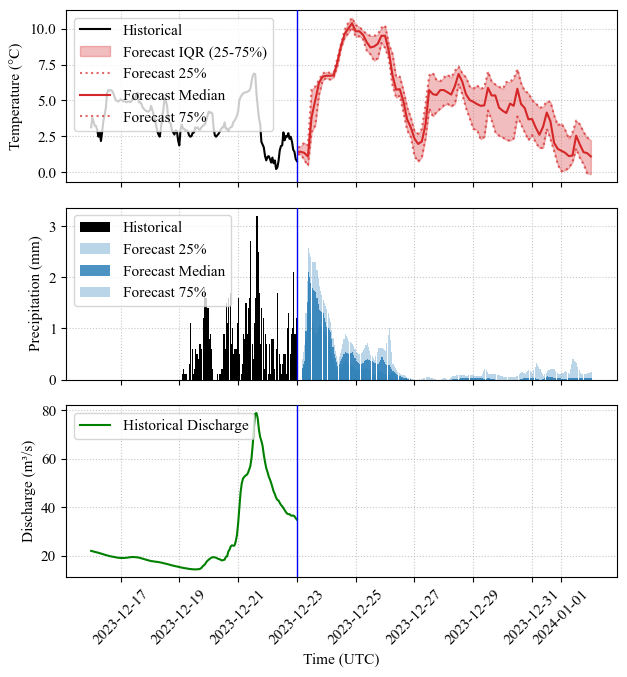

In [15]:
# --- Visualization Configuration ---

# --- Figure and Font Size ---
FIG_WIDTH = 6.4
FIG_HEIGHT = 7.5  # Increased height for 3 subplots
FONT_SIZE = 11

selected_basin = 'DE2'  # Updated to use new basin ID format (Oker reservoir catchment)
historical_days = 7 # Days of historical data before the forecast start

# Variable names (adjust for local historical data and new quartile naming convention)
historical_temp_var = 'temperature_2m_hist'  # Fixed: Use renamed variable from merge
historical_precip_var = 'precipitation'  # From local CSV files
historical_discharge_var = 'discharge_vol'  # From local CSV files
forecast_temp_vars = {
    'q25': 'temperature_2m_q25',
    'q50': 'temperature_2m_q50',
    'q75': 'temperature_2m_q75'
}
forecast_precip_vars = {
    'q25': 'precipitation_surface_q25',
    'q50': 'precipitation_surface_q50',
    'q75': 'precipitation_surface_q75'
}

# Conversion factor for precipitation: mm/s to mm/hr
MM_PER_S_TO_MM_PER_HR = 3600

# --- Define Specific Time for Plotting (e.g., Christmas 2023) ---
plot_forecast_init_time = None
if 'basin_forecast_historical_hourly' in locals() and basin_forecast_historical_hourly is not None:
    christmas_2023_target_time = pd.Timestamp('2023-12-23 00:00:00')
    print(f"Targeting plot around Christmas 2023 Forecast Initialization Time (UTC): {christmas_2023_target_time.strftime('%Y-%m-%d %H:%M:%S')}")
    
    # Find the closest available initialization time in the *merged* dataset
    available_times = pd.to_datetime(basin_forecast_historical_hourly.time.values)
    if christmas_2023_target_time in available_times:
        plot_forecast_init_time = christmas_2023_target_time
    else:
        time_diffs = np.abs(available_times - christmas_2023_target_time)
        closest_idx = time_diffs.argmin()
        plot_forecast_init_time = available_times[closest_idx]
        print(f"Exact Christmas date not found in data, using closest available init time for plotting: {plot_forecast_init_time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Using Initialization Time for Plotting (UTC): {plot_forecast_init_time.strftime('%Y-%m-%d %H:%M:%S')}")
else:
     print("Merged dataset not available to determine plot initialization time.")

# --- Data Preparation for Plotting ---
plot_data_available = False
historical_temp_data = None
historical_precip_data = None
historical_discharge_data = None
forecast_temp_data = {}
forecast_precip_data = {}
forecast_time_axis = None

# Proceed only if merged data and a plot time are available
if 'basin_forecast_historical_hourly' in locals() and basin_forecast_historical_hourly is not None and plot_forecast_init_time is not None:
    print(f"Preparing plot for basin: {selected_basin}")
    print(f"Available variables in dataset: {list(basin_forecast_historical_hourly.data_vars.keys())}")

    # Select data for the chosen basin
    basin_data = basin_forecast_historical_hourly.sel(basin=selected_basin)

    # Define time windows relative to the *plot* initialization time
    hist_end_time = plot_forecast_init_time
    hist_start_time = hist_end_time - timedelta(days=historical_days)
    print(f"Historical data window for plot (UTC): {hist_start_time.strftime('%Y-%m-%d %H:%M')} to {hist_end_time.strftime('%Y-%m-%d %H:%M:%S')}")

    # Extract historical and forecast slices based on plot_forecast_init_time
    try:
        # Slice historical data up to the plot init time
        historical_slice = basin_data.sel(time=slice(hist_start_time, hist_end_time))
        # Select the specific forecast initialized at plot_forecast_init_time
        latest_forecast = basin_data.sel(time=plot_forecast_init_time)
        print(f"Successfully selected historical slice for plot (Range: {historical_slice.time.min().values} to {historical_slice.time.max().values})")
        print(f"Successfully selected forecast data for plot (Init time: {latest_forecast.time.values})")
        plot_data_available = True
    except KeyError as e:
        print(f"Error selecting data slices for plot: {e}. Check time coordinates ({plot_forecast_init_time}) and availability.")
    except Exception as e:
        print(f"An unexpected error occurred during data selection for plot: {e}")

    if plot_data_available:
        # Extract specific variables if slices are valid
        # --- Load data into memory before plotting ---
        print("Loading data slices into memory for plotting...")
        try:
            # Historical Data
            if historical_temp_var in historical_slice:
                historical_temp_data = historical_slice[historical_temp_var].compute() # Load historical temp
                if historical_temp_data.isnull().all():
                    print(f"Warning: Historical temperature ('{historical_temp_var}') for plot is all NaN.")
                else:
                    print(f"Successfully loaded historical temperature data with {(~historical_temp_data.isnull()).sum().values} non-NaN values")
            else:
                print(f"Warning: Historical temperature variable '{historical_temp_var}' not found for plot.")
                print(f"Available historical variables: {[v for v in historical_slice.data_vars if 'lead_time' not in historical_slice[v].dims]}")

            if historical_precip_var in historical_slice:
                historical_precip_data = historical_slice[historical_precip_var].compute() # Load historical precip
                if historical_precip_data.isnull().all():
                    print(f"Warning: Historical precipitation ('{historical_precip_var}') for plot is all NaN.")
                else:
                    print(f"Successfully loaded historical precipitation data with {(~historical_precip_data.isnull()).sum().values} non-NaN values")
            else:
                print(f"Warning: Historical precipitation variable '{historical_precip_var}' not found for plot.")

            if historical_discharge_var in historical_slice:
                historical_discharge_data = historical_slice[historical_discharge_var].compute() # Load historical discharge
                if historical_discharge_data.isnull().all():
                    print(f"Warning: Historical discharge ('{historical_discharge_var}') for plot is all NaN.")
                else:
                    print(f"Successfully loaded historical discharge data with {(~historical_discharge_data.isnull()).sum().values} non-NaN values")
            else:
                print(f"Warning: Historical discharge variable '{historical_discharge_var}' not found for plot.")

            # Forecast Quartile Data - Temperature
            for quartile, var_name in forecast_temp_vars.items():
                if var_name in latest_forecast:
                    forecast_temp_data[quartile] = latest_forecast[var_name].compute()
                else:
                    print(f"Warning: Forecast temperature variable '{var_name}' not found for plot.")

            # Forecast Quartile Data - Precipitation
            for quartile, var_name in forecast_precip_vars.items():
                if var_name in latest_forecast:
                    forecast_precip_data[quartile] = latest_forecast[var_name].compute()
                else:
                    print(f"Warning: Forecast precipitation variable '{var_name}' not found for plot.")

            # Calculate forecast time axis relative to plot_forecast_init_time
            forecast_lead_hours = latest_forecast['lead_time'].values
            forecast_time_axis = plot_forecast_init_time + pd.to_timedelta(forecast_lead_hours, unit='h')
            print("Finished loading data slices.")
            # --- End loading data ---

        except Exception as e:
            print(f"Error extracting or loading variables for plotting: {e}")
            import traceback
            traceback.print_exc()
            plot_data_available = False # Prevent plotting if extraction fails
else:
    print("Combined dataset 'basin_forecast_historical_hourly' or 'plot_forecast_init_time' not found/determined. Cannot prepare plot data.")

# --- Create Plot ---
if plot_data_available:
    # Set the default font and size
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': FONT_SIZE
    })
    
    fig, axes = plt.subplots(3, 1, figsize=(FIG_WIDTH, FIG_HEIGHT), sharex=True)

    # --- Temperature Plot (ax1) ---
    ax1 = axes[0]
    temp_units = '°C'
    if forecast_temp_data.get('q50') is not None:
        temp_units = forecast_temp_data['q50'].attrs.get('units', '°C')

    # Plot Historical Temperature
    if historical_temp_data is not None and not historical_temp_data.isnull().all():
        valid_historical_temp = historical_temp_data.dropna(dim='time')
        if valid_historical_temp.size > 0:
            ax1.plot(valid_historical_temp['time'].values, valid_historical_temp.values,
                     label=f'Historical', color='black', linewidth=1.5, zorder=5)
            print(f"Plotting {valid_historical_temp.size} valid historical temperature points.")
        else:
            print("No valid historical temperature points to plot after dropping NaNs.")
    else:
        print("Historical temperature data is None or all NaN")

    # Plot Forecast Temperature Quartiles
    if forecast_temp_data and forecast_time_axis is not None:
        # Plot quartile band (25th to 75th percentile)
        if 'q25' in forecast_temp_data and 'q75' in forecast_temp_data:
            ax1.fill_between(forecast_time_axis,
                             forecast_temp_data['q25'].values,
                             forecast_temp_data['q75'].values,
                             color='#d62728', alpha=0.3, label='Forecast IQR (25-75%)', zorder=2)
        
        # Plot individual quartile lines
        quartile_styles = {'q25': ':', 'q50': '-', 'q75': ':'}
        quartile_alphas = {'q25': 0.7, 'q50': 1.0, 'q75': 0.7}
        quartile_labels = {'q25': 'Forecast 25%', 'q50': 'Forecast Median', 'q75': 'Forecast 75%'}
        
        for quartile, data in forecast_temp_data.items():
            ax1.plot(forecast_time_axis, data.values,
                     label=quartile_labels[quartile], color='#d62728', 
                     linestyle=quartile_styles[quartile], alpha=quartile_alphas[quartile], zorder=3)

    ax1.set_ylabel(f"Temperature ({temp_units})")
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle=':', alpha=0.7)
    ax1.axvline(plot_forecast_init_time, color='blue', linestyle='-', linewidth=1, label='Forecast Start', zorder=6)

    # --- Precipitation Plot (ax2) ---
    ax2 = axes[1]
    precip_units_hist = 'mm'
    precip_units_fcst = 'mm'
    forecast_bar_width_days = (forecast_time_axis[1] - forecast_time_axis[0]) / np.timedelta64(1, 'D') if len(forecast_time_axis) > 1 else 1/24

    # Plot Historical Precipitation (Bars)
    if historical_precip_data is not None and not historical_precip_data.isnull().all():
        valid_historical_precip = historical_precip_data.dropna(dim='time')
        if valid_historical_precip.size > 0:
            hist_time_diff = np.diff(valid_historical_precip['time'].values)
            hist_bar_width_days = (hist_time_diff[0] / np.timedelta64(1, 'D')) if len(hist_time_diff) > 0 else (1/24)
            ax2.bar(valid_historical_precip['time'].values, valid_historical_precip.values,
                    width=hist_bar_width_days * 0.9, label=f'Historical', color='black', align='edge', zorder=3)
            print(f"Plotting {valid_historical_precip.size} valid historical precipitation points.")
        else:
            print("No valid historical precipitation points to plot after dropping NaNs.")

    # Plot Forecast Precipitation Quartiles
    if forecast_precip_data and forecast_time_axis is not None:
        quartile_alphas = {'q25': 0.3, 'q50': 0.8, 'q75': 0.3}
        quartile_labels = {'q25': 'Forecast 25%', 'q50': 'Forecast Median', 'q75': 'Forecast 75%'}
        
        for quartile, data in forecast_precip_data.items():
            forecast_precip_mmhr = data.values * MM_PER_S_TO_MM_PER_HR
            ax2.bar(forecast_time_axis, forecast_precip_mmhr,
                    width=forecast_bar_width_days * 0.9, label=quartile_labels[quartile], 
                    color='#1f77b4', alpha=quartile_alphas[quartile], align='edge', zorder=2)

    ax2.set_ylabel(f"Precipitation ({precip_units_fcst})")
    ax2.legend(loc='upper left')
    ax2.grid(True, linestyle=':', alpha=0.7)
    ax2.axvline(plot_forecast_init_time, color='blue', linestyle='-', linewidth=1, zorder=4)

    # --- Discharge Plot (ax3) ---
    ax3 = axes[2]
    discharge_units = 'm³/s'

    # Plot Historical Discharge
    if historical_discharge_data is not None and not historical_discharge_data.isnull().all():
        valid_historical_discharge = historical_discharge_data.dropna(dim='time')
        if valid_historical_discharge.size > 0:
            ax3.plot(valid_historical_discharge['time'].values, valid_historical_discharge.values,
                     label=f'Historical Discharge', color='green', linewidth=1.5, zorder=5)
            print(f"Plotting {valid_historical_discharge.size} valid historical discharge points.")
        else:
            print("No valid historical discharge points to plot after dropping NaNs.")
    else:
        print("Historical discharge data is None or all NaN")

    ax3.set_ylabel(f"Discharge ({discharge_units})")
    ax3.legend(loc='upper left')
    ax3.grid(True, linestyle=':', alpha=0.7)
    ax3.axvline(plot_forecast_init_time, color='blue', linestyle='-', linewidth=1, label='Forecast Start', zorder=6)

    # --- Final Formatting ---
    plt.xlabel("Time (UTC)")
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # --- Save Plot (BEFORE plt.show()) ---
    plot_filename = os.path.join(output_dir, f"forecast_quartiles_plot_{selected_basin}_{plot_forecast_init_time.strftime('%Y%m%d_%H%M')}.pdf")
    try:
        fig.savefig(plot_filename, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Plot saved to {plot_filename}")
    except Exception as e:
        print(f"Error saving plot: {e}")
        
    # --- Show Plot ---
    plt.show()
else:
    print("Skipping plot generation because necessary data could not be prepared.")